In [3]:
import pandas as pd
from pathlib import Path
import json
import seaborn as sns
import matplotlib.pyplot as plt

# Metrics list

- IR evaluation + generation from pipeline experiments
    these have embeddings and BM25 search metrics
- ColBERT metrics

## Pipeline approach metrics

Each evaluation comes from an experiment

Experiment is using either BM25 or 2 sentence transformer models

In [4]:
evaluation_run_id = "9ca3d897-eed8-44cf-ab0e-ab1d61f93f6f"
evaluation_dir = f"/home/kuba/.config/zenml/local_stores/da10b373-8846-4d7e-bac7-2c36a7b352b4/get_ir_experiments_results/ir_experiments_results/{evaluation_run_id}"

generation_results = []
for exp_id in [0,1,2]:
    generation_part_path = Path(evaluation_dir) / str(exp_id) / "data.json"
    with open(generation_part_path) as f:
        generation_results_part = json.loads(json.loads(f.read()))
    generation_results.append(generation_results_part) 

In [5]:
generation_results[0]["generation_metrics"]['0'][0]

{'repo': 'karlgodin/DP10-hockey-pose-estimation',
 'tasks': 'pose estimation, ',
 'true_tasks': ['pose estimation'],
 'generated_text': 'pose estimation, ',
 'prompt_info': {'content': 'SuperRNModel.py, classifier/FPhi.py, classifier/GTheta.py, classifier/joints.py, classifier/SBUDataset/sbu_extractor.py, getGridSearchFromParameterList, getGridSearchFromBestRuns, get_combinations_inter, get_combinations_intra, generatorKFold, GTheta, parse_clip, findIdxesOfMinInDataFrame, distancePoses, TestTubeLogger',
  'generated_text': '\n## repository\nluheng/deep_srl\n## files\npreprocess/process_conll05.py, preprocess/process_conll2012.py, preprocess/jackknifing/jackknife.py, preprocess/jackknifing/jackknife_conll2012.py, python/neural_srl/shared/configuration.py, evaluate_tagger, ResidualLSTMLayer, HighwayLSTMLayer, HighwayRANLayer, SimpleHighwayLSTMLayer, get_postag_test_data, get_srl_test_data, read_gold_props, get_srl_sentences, get_srl_sentences\n## tags\n[semantic role labeling]\n\n## repo

In [4]:
pipeline_experiment_metadata = [
    generation_results[i]["ir_config"]
    for i in range(len(generation_results))
]

In [5]:
pipeline_experiment_metadata

[{'embedder_config': {'query_embedder_path': 'sentence-transformers/all-mpnet-base-v2',
   'document_embedder_path': 'sentence-transformers/all-mpnet-base-v2',
   'doc_max_length': None,
   'query_max_length': None},
  'column_config': {'document_cols': ['dependencies', 'tasks'],
   'query_col': 'true_tasks',
   'list_cols': []}},
 {'embedder_config': {'query_embedder_path': 'sentence-transformers/all-mpnet-base-v2',
   'document_embedder_path': 'sentence-transformers/all-mpnet-base-v2',
   'doc_max_length': None,
   'query_max_length': None},
  'column_config': {'document_cols': ['dependencies'],
   'query_col': 'true_tasks',
   'list_cols': []}},
 {'embedder_config': {'query_embedder_path': 'sentence-transformers/all-mpnet-base-v2',
   'document_embedder_path': 'sentence-transformers/all-mpnet-base-v2',
   'doc_max_length': None,
   'query_max_length': None},
  'column_config': {'document_cols': ['tasks'],
   'query_col': 'true_tasks',
   'list_cols': []}}]

In [6]:
pipeline_result_dfs = []

for i in range(3):
    res = generation_results[i]
    experiment_dfs = []
    
    for gen_id in range(3):
        gen_df = pd.DataFrame.from_records(res["per_query_metrics"][str(gen_id)])
        gen_df["generation"] = gen_id
        experiment_dfs.append(gen_df)
    pipeline_result_dfs.append(pd.concat(experiment_dfs))

In [7]:
def get_generation_metrics(results):
    generation_metrics_dfs = []
    for gen in results[0]["generation_metrics"].keys():
        df = pd.DataFrame.from_records(results[0]["generation_metrics"][gen])
        generation_metrics_dfs.append(df)
    return pd.concat(generation_metrics_dfs)

def get_per_query_generation_metrics_df(generation_metrics_df):
    numeric_cols = generation_metrics_df.select_dtypes("number").columns
    return (generation_metrics_df[["true_tasks"] + list(numeric_cols)]
            .explode("true_tasks")
            .groupby(["true_tasks", "generation"])
            .agg("mean")
            .reset_index(drop=False))

In [8]:
generation_metrics_df = get_generation_metrics(generation_results)

In [9]:
raw_per_query_generation_metrics_df = get_per_query_generation_metrics_df(generation_metrics_df).rename({"true_tasks": "query"}, axis=1)

<Axes: ylabel='Frequency'>

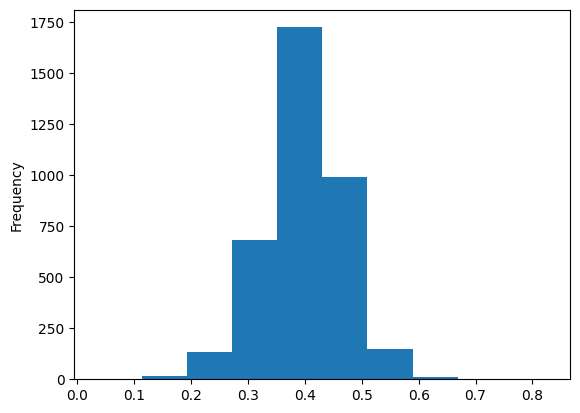

In [10]:
raw_per_query_generation_metrics_df["sentence_transformer_similarity"].plot.hist()

In [11]:
all_per_query_generation_metrics_df = raw_per_query_generation_metrics_df.drop(columns=["generation"]).groupby(["query"]).agg("min")

In [12]:
all_per_query_generation_metrics_df

,bertscore_precision,bertscore_recall,bertscore_f1,rouge1,rouge2,rougeL,rougeLsum,wmd,sentence_transformer_similarity
query,,,,,,,,,
,0.726188,0.713162,0.718859,0.089503,0.024851,0.089503,0.089503,inf,0.318732
2d human pose estimation,0.868856,0.835465,0.851824,0.167073,0.074440,0.147942,0.147942,inf,0.492979
2d object detection,0.855739,0.833312,0.844749,0.123319,0.051707,0.121231,0.121231,0.887832,0.455977
2d semantic segmentation,0.844973,0.827406,0.836091,0.075253,0.000000,0.075253,0.075253,1.008226,0.333121
3d absolute human pose estimation,0.869172,0.829954,0.849021,0.142222,0.035495,0.125415,0.125415,0.733737,0.514665
...,...,...,...,...,...,...,...,...,...
zero shot learning,0.854264,0.834764,0.844195,0.095456,0.032644,0.092337,0.092337,inf,0.350707
zero shot object detection,0.839715,0.845585,0.843473,0.142222,0.057143,0.142222,0.142222,0.731136,0.359693
zero shot text search,0.833501,0.798029,0.823688,0.125000,0.000000,0.083333,0.083333,0.948109,0.397481


In [13]:
raw_pipeline_metrics_df = pd.concat([
    pipeline_result_dfs[i].assign(experiment_id=i)
    for i in range(len(pipeline_result_dfs))
])

## ColBERT metrics

In [14]:
n_prev_experiments = 3
colbert_experiments = ["code", "readme", "combined", "librarian", "dependency"]

colbert_metrics_dir = Path("~/Projects/uhackathons/fastrag_util/results").expanduser()
colbert_metrics_df = pd.concat([
    pd.read_csv(colbert_metrics_dir / f"{exp_type}_evaluation.csv").assign(experiment_id=n_prev_experiments + i)
    for i, exp_type in enumerate(colbert_experiments)
])

colbert_metrics_df = colbert_metrics_df.drop(columns=["Unnamed: 0", "query_doc_count", "query_label"])
colbert_metrics_df["accuracy@10"] = colbert_metrics_df["accuracy@10"] * 1.0

Have to ensure we calculate metrics for the same queries

In [15]:
pipeline_metrics_df = raw_pipeline_metrics_df[raw_pipeline_metrics_df["query"].isin(colbert_metrics_df["query"])]
per_query_generation_metrics_df = all_per_query_generation_metrics_df[all_per_query_generation_metrics_df.index.isin(colbert_metrics_df["query"])]

In [16]:
pipeline_metrics_df.groupby("experiment_id")[["accuracy@10", "hits@10"]].agg("mean")

,accuracy@10,hits@10
experiment_id,,
0,0.569383,2.110132
1,0.410793,1.775330
2,0.573789,1.441630


In [17]:
colbert_metrics_df.groupby("experiment_id")[["accuracy@10", "hits@10"]].agg("mean")

,accuracy@10,hits@10
experiment_id,,
3,0.563877,1.588106
4,0.864537,4.559471
5,0.848018,4.427313
6,0.481278,0.955947
7,0.360132,0.806167


In [18]:
colbert_metrics_df.set_index("query").select_dtypes(["number", bool])

,hits@10,accuracy@10,experiment_id
query,,,
general classification,4,1.0,3
image classification,4,1.0,3
semantic segmentation,6,1.0,3
object detection,7,1.0,3
reinforcement learning,8,1.0,3
...,...,...,...
seismic imaging,0,0.0,7
handwritten text recognition,0,0.0,7
automated feature engineering,0,0.0,7


In [19]:
grouped_pipeline_metrics_df = pipeline_metrics_df.drop(columns=["generation"]).groupby(["query", "experiment_id"]).agg("mean").reset_index()
ir_metrics_df = pd.concat([grouped_pipeline_metrics_df[colbert_metrics_df.columns], colbert_metrics_df])

In [20]:
corr_dfs = []
combined_metrics_dfs = []

for exp_id in ir_metrics_df["experiment_id"].unique():
    ir_exp_metrics_df = ir_metrics_df[ir_metrics_df["experiment_id"] == exp_id].set_index("query").select_dtypes("number")
    exp_metrics_df = ir_exp_metrics_df.merge(per_query_generation_metrics_df, left_index=True, right_index=True)
    combined_metrics_dfs.append(exp_metrics_df)
    all_corr_df = exp_metrics_df.drop(columns=["experiment_id"]).corr(method="spearman")
    # select only ir vs generation metrics
    corr_df = all_corr_df[["hits@10", "accuracy@10"]].drop(["hits@10", "accuracy@10"])
    corr_dfs.append(corr_df)

{'embedder_config': {'query_embedder_path': 'sentence-transformers/all-mpnet-base-v2', 'document_embedder_path': 'sentence-transformers/all-mpnet-base-v2', 'doc_max_length': None, 'query_max_length': None}, 'column_config': {'document_cols': ['dependencies', 'tasks'], 'query_col': 'true_tasks', 'list_cols': []}}


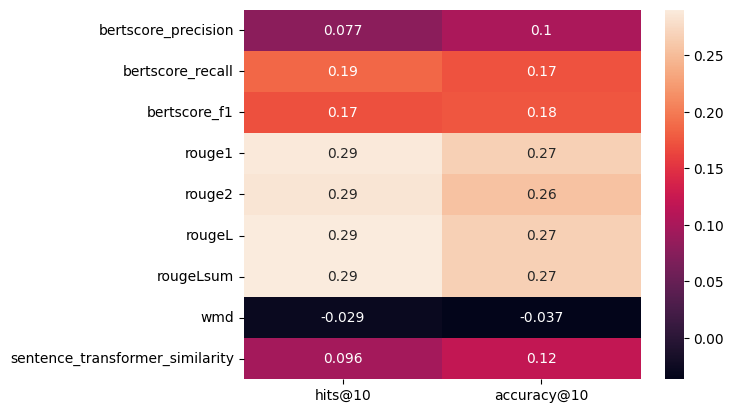

{'embedder_config': {'query_embedder_path': 'sentence-transformers/all-mpnet-base-v2', 'document_embedder_path': 'sentence-transformers/all-mpnet-base-v2', 'doc_max_length': None, 'query_max_length': None}, 'column_config': {'document_cols': ['dependencies'], 'query_col': 'true_tasks', 'list_cols': []}}


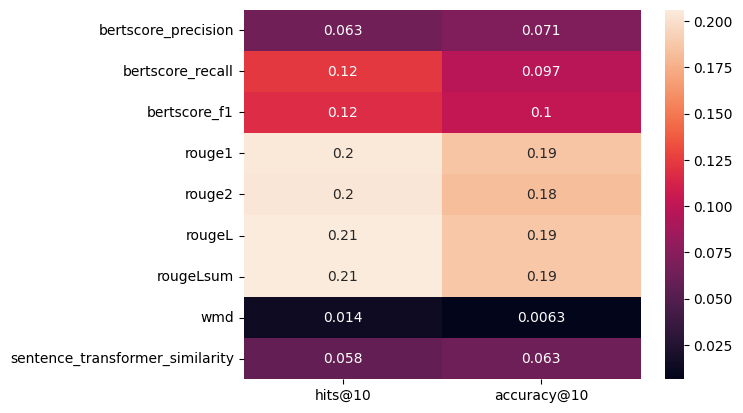

{'embedder_config': {'query_embedder_path': 'sentence-transformers/all-mpnet-base-v2', 'document_embedder_path': 'sentence-transformers/all-mpnet-base-v2', 'doc_max_length': None, 'query_max_length': None}, 'column_config': {'document_cols': ['tasks'], 'query_col': 'true_tasks', 'list_cols': []}}


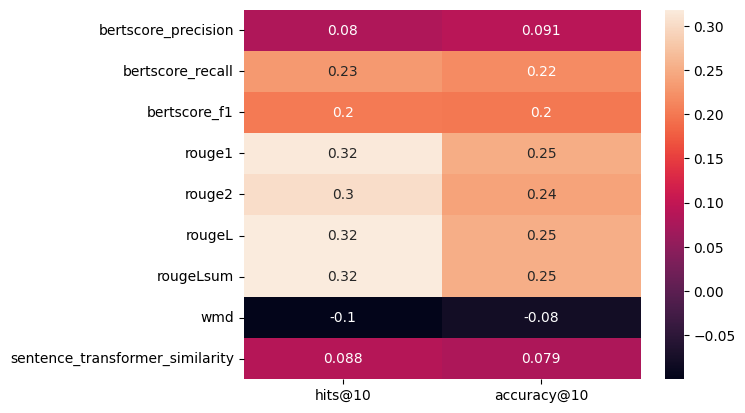

code


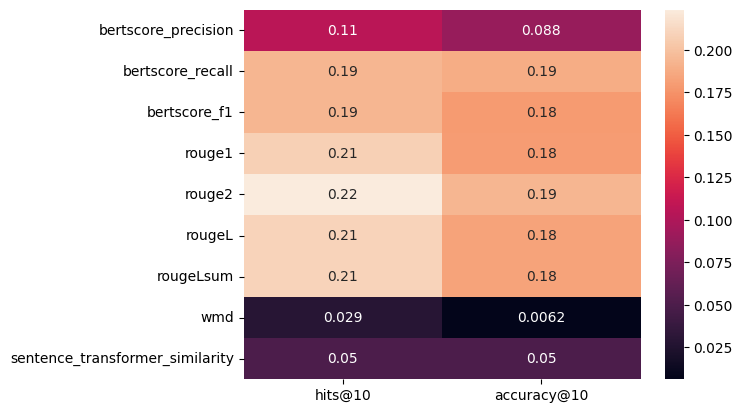

readme


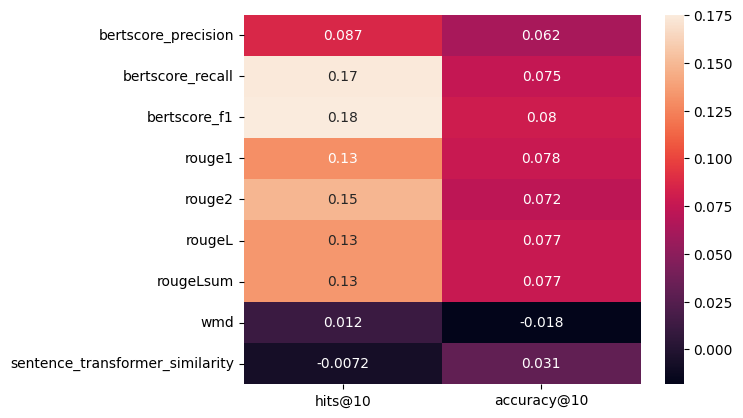

combined


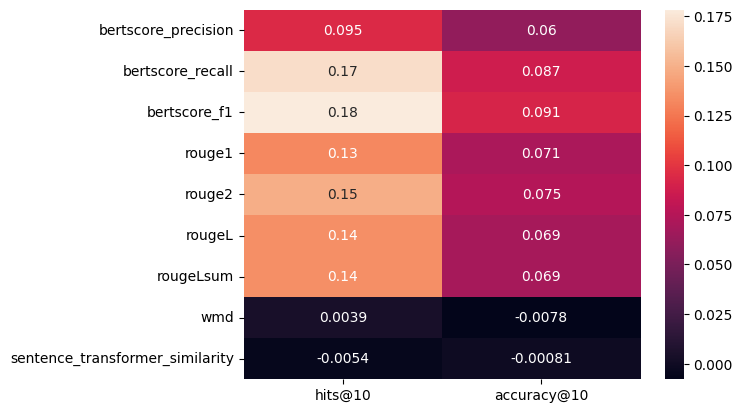

librarian


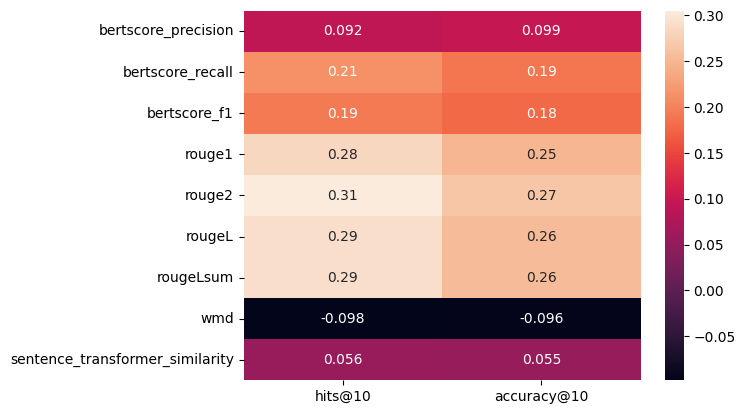

dependency


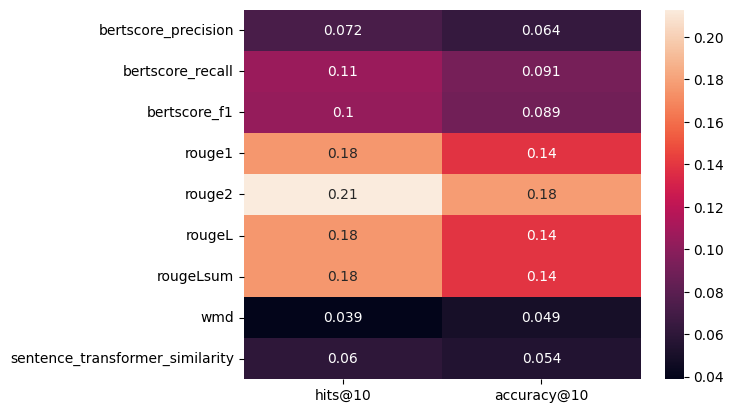

In [22]:
for exp_name, corr_df in zip(pipeline_experiment_metadata + colbert_experiments, corr_dfs):
    print(exp_name)
    sns.heatmap(corr_df, annot=True)
    plt.show()

In [23]:
per_query_generation_metrics_df.describe()

/home/kuba/.cache/pypoetry/virtualenvs/github-search-hM2r__Rf-py3.10/lib/python3.10/site-packages/pandas/core/nanops.py:1010: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)
/home/kuba/.cache/pypoetry/virtualenvs/github-search-hM2r__Rf-py3.10/lib/python3.10/site-packages/numpy/lib/function_base.py:4655: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)


,bertscore_precision,bertscore_recall,bertscore_f1,rouge1,rouge2,rougeL,rougeLsum,wmd,sentence_transformer_similarity
count,908.000000,908.000000,908.000000,908.000000,908.000000,908.000000,908.000000,908.000000,908.000000
mean,0.848729,0.836867,0.842707,0.087180,0.024513,0.083237,0.083237,inf,0.382815
std,0.009888,0.014783,0.009815,0.039349,0.020233,0.037464,0.037464,NaN,0.058146
min,0.803562,0.773483,0.797863,0.000000,0.000000,0.000000,0.000000,0.668755,0.151549
25%,0.842459,0.827780,0.836302,0.060295,0.009509,0.057887,0.057887,0.953500,0.344710
50%,0.849119,0.838636,0.843748,0.084355,0.020778,0.079963,0.079963,1.006385,0.383532
75%,0.854733,0.847138,0.849310,0.111575,0.034615,0.105696,0.105696,NaN,0.423234
max,0.877951,0.875034,0.872709,0.216293,0.109956,0.209305,0.209305,inf,0.528725


In [24]:
from scipy import stats


In [25]:
combined_metrics_dfs[0]

,hits@10,accuracy@10,experiment_id,bertscore_precision,bertscore_recall,bertscore_f1,rouge1,rouge2,rougeL,rougeLsum,wmd,sentence_transformer_similarity
query,,,,,,,,,,,,
2d human pose estimation,5.0,1.0,0,0.868856,0.835465,0.851824,0.167073,0.074440,0.147942,0.147942,inf,0.492979
2d object detection,0.0,0.0,0,0.855739,0.833312,0.844749,0.123319,0.051707,0.121231,0.121231,0.887832,0.455977
3d action recognition,2.0,1.0,0,0.855952,0.824345,0.839573,0.067173,0.016410,0.061735,0.061735,1.016927,0.392527
3d classification,0.0,0.0,0,0.874119,0.819037,0.845530,0.138885,0.056012,0.133788,0.133788,0.912552,0.521483
3d depth estimation,0.0,0.0,0,0.862131,0.839987,0.851932,0.076669,0.029944,0.076669,0.076669,0.935026,0.362324
...,...,...,...,...,...,...,...,...,...,...,...,...
word sense induction,0.0,0.0,0,0.840089,0.842632,0.841383,0.041270,0.013889,0.041270,0.041270,0.987642,0.344638
word similarity,5.0,1.0,0,0.848839,0.842406,0.845192,0.079336,0.017316,0.076568,0.076568,1.016608,0.413014
word translation,2.0,1.0,0,0.845735,0.826987,0.836101,0.060656,0.015838,0.060656,0.060656,0.939942,0.447641


In [26]:
for exp_name, df in zip(pipeline_experiment_metadata + colbert_experiments, combined_metrics_dfs):
    print(exp_name)
    for n_hits in [0,1]:
        print(f"  metrics for queries where hits <= {n_hits}")
        selected_df = df[(n_hits <= df["hits@10"]) &  (df["hits@10"] <= n_hits + 1)]
        mean_metric_values = (selected_df.drop(columns=["experiment_id", "hits@10", "accuracy@10"]).mean().to_dict())
        for k, v in mean_metric_values.items():
            print("    ", k)
            print("    ", round(stats.percentileofscore(per_query_generation_metrics_df[k], v), 3))
    plt.show()

{'embedder_config': {'query_embedder_path': 'sentence-transformers/all-mpnet-base-v2', 'document_embedder_path': 'sentence-transformers/all-mpnet-base-v2', 'doc_max_length': None, 'query_max_length': None}, 'column_config': {'document_cols': ['dependencies', 'tasks'], 'query_col': 'true_tasks', 'list_cols': []}}
  metrics for queries where hits <= 0
     bertscore_precision
     46.035
     bertscore_recall
     39.317
     bertscore_f1
     40.969
     rouge1
     44.824
     rouge2
     49.67
     rougeL
     45.485
     rougeLsum
     45.485
     wmd
     84.196
     sentence_transformer_similarity
     46.145
  metrics for queries where hits <= 1
     bertscore_precision
     55.507
     bertscore_recall
     48.128
     bertscore_f1
     51.762
     rouge1
     58.37
     rouge2
     58.7
     rougeL
     58.04
     rougeLsum
     58.04
     wmd
     84.196
     sentence_transformer_similarity
     55.396
{'embedder_config': {'query_embedder_path': 'sentence-transformers/all-mpnet

In [27]:
colbert_code_metrics_df = combined_metrics_dfs[0]

In [28]:
all_experiment_tags = [
    ("repository signature", "sentence_transformers"),
    ("dependency signature","sentence_transformers"),
    ("librarian output", "sentence_transformers"),
    ("code", "colbert"),
    ("readme", "colbert"),
    ("code + readme", "colbert"),
    ("repository signature", "colbert"),
    ("dependency signature", "colbert")
]

In [29]:
import io
prev_metrics_table = """
text_cols	retriever_name	Hits@1	Hits@5	Hits@10	Hits@25	Accuracy@1	Accuracy@5	Accuracy@10	Accuracy@25
['readme']	bm25	0.593	2.471	4.248	8.046	0.593	0.842	0.901	0.939
['tasks', 'readme']	bm25	0.59	2.45	4.21	7.935	0.59	0.838	0.899	0.935
['readme']	bm25-sentence-transformers_all-mpnet-base-v2	0.549	2.27	4.032	8.191	0.549	0.821	0.887	0.943
['readme']	sentence-transformers_all-mpnet-base-v2	0.554	2.26	3.842	7.274	0.554	0.794	0.85	0.903
['tasks', 'readme']	bm25-sentence-transformers_all-mpnet-base-v2	0.469	2.005	3.547	7.523	0.469	0.8	0.873	0.939
['tasks', 'readme']	sentence-transformers_all-mpnet-base-v2	0.452	1.85	3.179	6.124	0.452	0.746	0.813	0.881
['tasks', 'dependencies']	sentence-transformers_all-mpnet-base-v2	0.172	0.669	1.159	2.252	0.172	0.394	0.498	0.614
['tasks', 'dependencies']	bm25-sentence-transformers_all-mpnet-base-v2	0.134	0.598	1.085	2.235	0.134	0.369	0.486	0.615
['dependencies']	sentence-transformers_all-mpnet-base-v2	0.191	0.652	1.051	2.036	0.191	0.369	0.443	0.555
['tasks', 'dependencies']	bm25	0.158	0.563	0.957	1.809	0.158	0.346	0.43	0.527
['tasks']	bm25-sentence-transformers_all-mpnet-base-v2	0.125	0.533	0.94	1.866	0.125	0.335	0.441	0.556
['tasks']	sentence-transformers_all-mpnet-base-v2	0.131	0.533	0.925	1.809	0.131	0.344	0.431	0.54
['tasks']	bm25	0.141	0.532	0.919	1.739	0.141	0.338	0.421	0.516
['dependencies']	bm25-sentence-transformers_all-mpnet-base-v2	0.109	0.483	0.869	1.704	0.109	0.299	0.391	0.525
['dependencies']	bm25	0.091	0.288	0.411	0.673	0.091	0.176	0.202	0.27
""".strip()

In [30]:
prev_experiment_results_df = pd.read_csv(io.StringIO(prev_metrics_table), sep="\t")

In [31]:
bm25_experiment_results = prev_experiment_results_df[(prev_experiment_results_df["retriever_name"] == "bm25")][["Accuracy@10", "Hits@10"]].reset_index(drop=True)

In [32]:
bm25_experiment_results.columns = [colname.lower() for colname in bm25_experiment_results.columns]
bm25_experiment_results["document"] = ["readme", "readme + librarian output", "repository signature", "librarian output", "dependency signature"]
bm25_experiment_results["retrieval"] = "bm25"

In [33]:
bm25_experiment_results

,accuracy@10,hits@10,document,retrieval
0,0.901,4.248,readme,bm25
1,0.899,4.210,readme + librarian output,bm25
2,0.430,0.957,repository signature,bm25
3,0.421,0.919,librarian output,bm25
4,0.202,0.411,dependency signature,bm25


In [34]:
experiment_metric_results = {
    exp_tag: df[["accuracy@10", "hits@10"]].mean()
    for exp_tag, df in zip(all_experiment_tags, combined_metrics_dfs)
}

In [35]:
new_experiment_results = (
    pd.concat([
        pd.DataFrame([exp_metrics_df]).assign(document=document_type, retrieval=ir_method)
        for (document_type, ir_method), exp_metrics_df in experiment_metric_results.items()
    ])[["document", "retrieval", "accuracy@10", "hits@10"]].round(3)
)

In [36]:
all_experiment_results_df = pd.concat([bm25_experiment_results, new_experiment_results]).sort_values("accuracy@10", ascending=False).reset_index(drop=True)

In [37]:
all_experiment_results_df

,accuracy@10,hits@10,document,retrieval
0,0.901,4.248,readme,bm25
1,0.899,4.210,readme + librarian output,bm25
2,0.865,4.559,readme,colbert
3,0.848,4.427,code + readme,colbert
4,0.574,1.442,librarian output,sentence_transformers
5,0.569,2.110,repository signature,sentence_transformers
6,0.564,1.588,code,colbert
7,0.481,0.956,repository signature,colbert
8,0.430,0.957,repository signature,bm25
9,0.421,0.919,librarian output,bm25


In [38]:
all_experiment_results_df.to_csv("../results/thesis/all_method_results.csv")

In [39]:
COL_ORDER = ['document', 'retrieval', 'accuracy@10', 'hits@10']

In [40]:
basic_documents_results_df = all_experiment_results_df[
    ~all_experiment_results_df["document"].isin(["repository signature", "librarian output"]) 
]
basic_documents_results_df.reset_index(drop=True).to_csv("../results/thesis/basic_documents_results.csv")

In [41]:
print(basic_documents_results_df[COL_ORDER].to_latex(index=False).replace("\\\n", "\\ \hline\n"))

\begin{tabular}{llrr}
\toprule
document & retrieval & accuracy@10 & hits@10 \\ \hline
\midrule
readme & bm25 & 0.901000 & 4.248000 \\ \hline
readme + librarian output & bm25 & 0.899000 & 4.210000 \\ \hline
readme & colbert & 0.865000 & 4.559000 \\ \hline
code + readme & colbert & 0.848000 & 4.427000 \\ \hline
code & colbert & 0.564000 & 1.588000 \\ \hline
dependency signature & sentence_transformers & 0.411000 & 1.775000 \\ \hline
dependency signature & colbert & 0.360000 & 0.806000 \\ \hline
dependency signature & bm25 & 0.202000 & 0.411000 \\ \hline
\bottomrule
\end{tabular}



In [42]:
print(all_experiment_results_df[COL_ORDER].to_latex(index=False).replace("\\\n", "\\ \hline\n"))

\begin{tabular}{llrr}
\toprule
document & retrieval & accuracy@10 & hits@10 \\ \hline
\midrule
readme & bm25 & 0.901000 & 4.248000 \\ \hline
readme + librarian output & bm25 & 0.899000 & 4.210000 \\ \hline
readme & colbert & 0.865000 & 4.559000 \\ \hline
code + readme & colbert & 0.848000 & 4.427000 \\ \hline
librarian output & sentence_transformers & 0.574000 & 1.442000 \\ \hline
repository signature & sentence_transformers & 0.569000 & 2.110000 \\ \hline
code & colbert & 0.564000 & 1.588000 \\ \hline
repository signature & colbert & 0.481000 & 0.956000 \\ \hline
repository signature & bm25 & 0.430000 & 0.957000 \\ \hline
librarian output & bm25 & 0.421000 & 0.919000 \\ \hline
dependency signature & sentence_transformers & 0.411000 & 1.775000 \\ \hline
dependency signature & colbert & 0.360000 & 0.806000 \\ \hline
dependency signature & bm25 & 0.202000 & 0.411000 \\ \hline
\bottomrule
\end{tabular}



In [43]:
readme_results_df = all_experiment_results_df[all_experiment_results_df["document"].str.contains("readme")]
readme_results_df.reset_index(drop=True).to_csv("../results/thesis/readme_results.csv")

In [44]:
combined_metrics_dfs[0].shape

(908, 12)

## KORELACJE

In [45]:
for exp_name, df in zip(all_experiment_tags, combined_metrics_dfs):
    print(exp_name)
    print(df.corr("spearman").loc[["accuracy@10", "hits@10"], ["rougeL", "sentence_transformer_similarity"]])

('repository signature', 'sentence_transformers')
               rougeL  sentence_transformer_similarity
accuracy@10  0.267124                         0.120335
hits@10      0.290422                         0.096303
('dependency signature', 'sentence_transformers')
               rougeL  sentence_transformer_similarity
accuracy@10  0.187229                         0.062673
hits@10      0.206161                         0.057712
('librarian output', 'sentence_transformers')
               rougeL  sentence_transformer_similarity
accuracy@10  0.252103                         0.079258
hits@10      0.318202                         0.087537
('code', 'colbert')
               rougeL  sentence_transformer_similarity
accuracy@10  0.183282                         0.050302
hits@10      0.209670                         0.049885
('readme', 'colbert')
               rougeL  sentence_transformer_similarity
accuracy@10  0.076687                         0.030639
hits@10      0.134294                     

In [46]:
print(combined_metrics_dfs[2].corr("spearman").loc[["accuracy@10", "hits@10"], ["rougeL", "sentence_transformer_similarity"]].round(3).to_latex().replace("\\\n", "\\ \hline\n"))

\begin{tabular}{lrr}
\toprule
 & rougeL & sentence_transformer_similarity \\ \hline
\midrule
accuracy@10 & 0.252000 & 0.079000 \\ \hline
hits@10 & 0.318000 & 0.088000 \\ \hline
\bottomrule
\end{tabular}



## CO SIĘ DZIEJE DLA 10% NAJTRUDNIEJSZYCH REPO WG METRYK GENERACJI

('repository signature', 'sentence_transformers')
  metrics for queries with 10% worst rougeL


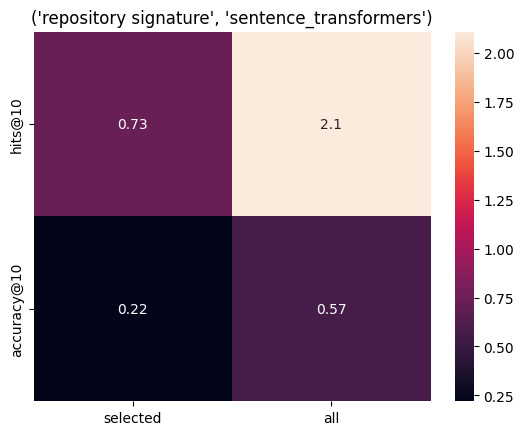

('dependency signature', 'sentence_transformers')
  metrics for queries with 10% worst rougeL


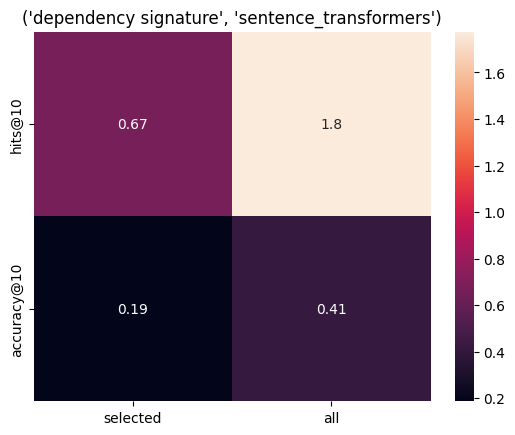

('librarian output', 'sentence_transformers')
  metrics for queries with 10% worst rougeL


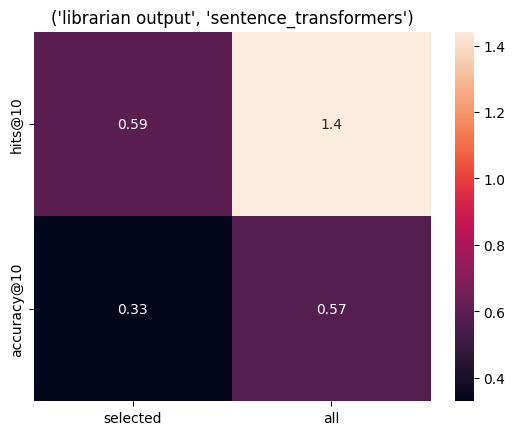

('code', 'colbert')
  metrics for queries with 10% worst rougeL


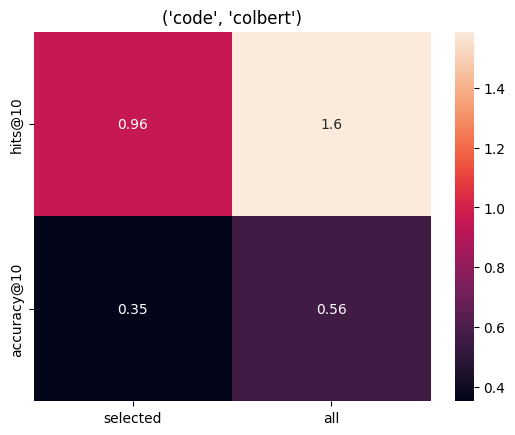

('readme', 'colbert')
  metrics for queries with 10% worst rougeL


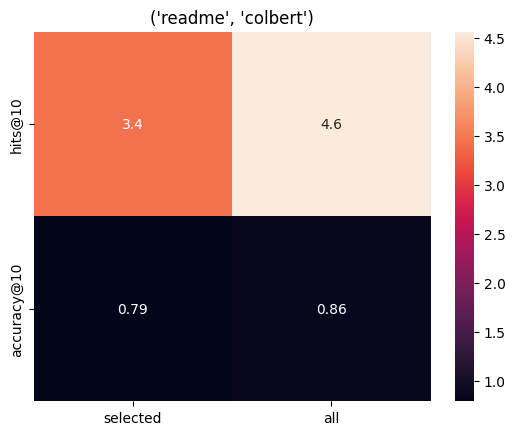

('code + readme', 'colbert')
  metrics for queries with 10% worst rougeL


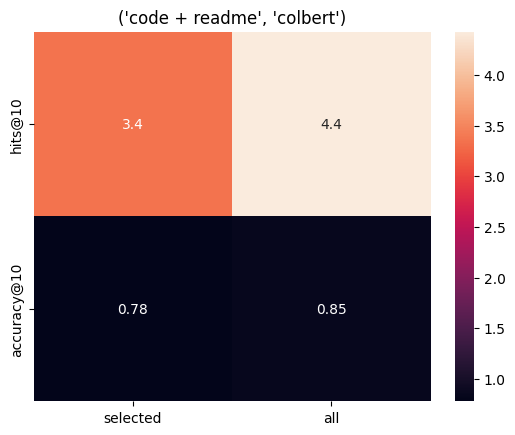

('repository signature', 'colbert')
  metrics for queries with 10% worst rougeL


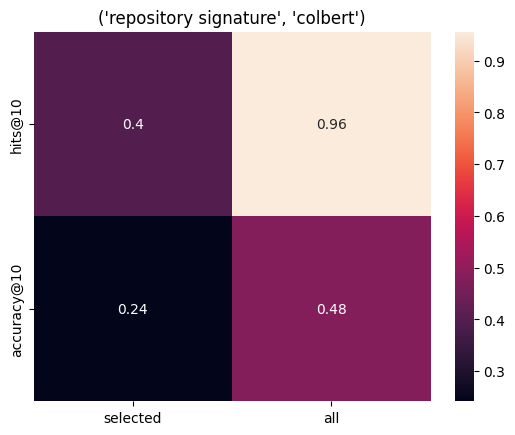

('dependency signature', 'colbert')
  metrics for queries with 10% worst rougeL


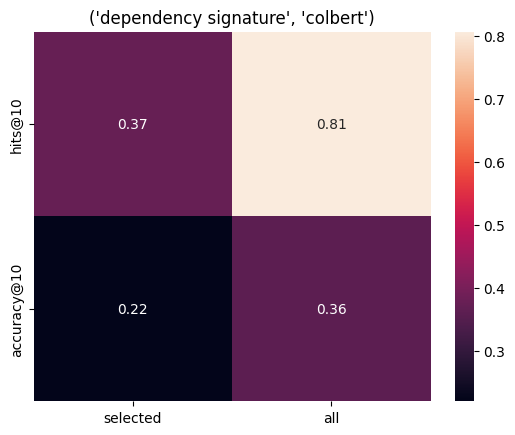

In [106]:
compared_metric = "rougeL"
metric_worst_decile = per_query_generation_metrics_df[compared_metric].quantile(0.1)

for exp_name, df in zip(all_experiment_tags, combined_metrics_dfs):
    print(exp_name)
    print(f"  metrics for queries with 10% worst {compared_metric}")
    selected_df = df[df[compared_metric] < metric_worst_decile]
    selected_metric_comparison_df = pd.DataFrame({
        "selected": selected_df[["hits@10", "accuracy@10"]].mean(),
        "all": df[["hits@10", "accuracy@10"]].mean()
    })
    plt.title(str(exp_name))
    sns.heatmap(selected_metric_comparison_df, annot=True)
    plt.show()

In [138]:
def get_metric_diffs(exp_names, exp_metrics_df):

    diff_dfs = []
    for exp_name, df in zip(exp_names, exp_metrics_df):
        selected_df = df[df[compared_metric] < metric_worst_decile]
        selected_metrics_df = selected_df[["hits@10", "accuracy@10"]].mean()
        all_metrics_df = df[["hits@10", "accuracy@10"]].mean()
        exp_difference_df = (all_metrics_df - selected_metrics_df)
        diffs = pd.concat([all_metrics_df, selected_metrics_df, exp_difference_df, 100 * (exp_difference_df / all_metrics_df)])
        diffs.index = ["hits@10", "accuracy@10", "worst records hits@10", "worst records accuracy@10", "hits@10 difference", "accuracy@10 difference", "% hits@10 difference ", "% accuracy@10 difference"]
        diff_dfs.append(diffs)
    diff_df = pd.DataFrame(diff_dfs)[["accuracy@10", "worst records accuracy@10", "accuracy@10 difference", "% accuracy@10 difference", "hits@10", "worst records hits@10", "hits@10 difference", "% hits@10 difference "]].round(3)
    for col in diff_df:
        if "%" in col:
            diff_df[col] = diff_df[col].round(1).astype(str) + "%"
    return diff_df

In [139]:
worst_pctile_drops = pd.concat([
    pd.DataFrame(all_experiment_tags, columns=["document", "retriever"]),
    get_metric_diffs(all_experiment_tags, combined_metrics_dfs)
], axis=1)

In [152]:
#worst_pctile_drops[~worst_pctile_drops["document"].str.contains("readme")].reset_index(drop=True).round(3).to_csv(f"../results/thesis/worst_{compared_metric}_drops.csv")

In [141]:
print(worst_pctile_drops[~worst_pctile_drops["document"].str.contains("readme")].to_latex().replace("\\\n", "\\ \hline\n"))

\begin{tabular}{lllrrrlrrrl}
\toprule
 & document & retriever & accuracy@10 & worst records accuracy@10 & accuracy@10 difference & % accuracy@10 difference & hits@10 & worst records hits@10 & hits@10 difference & % hits@10 difference  \\ \hline
\midrule
0 & repository signature & sentence_transformers & 0.569000 & 0.220000 & 0.350000 & 61.4% & 2.110000 & 0.725000 & 1.385000 & 65.6% \\ \hline
1 & dependency signature & sentence_transformers & 0.411000 & 0.187000 & 0.224000 & 54.5% & 1.775000 & 0.670000 & 1.105000 & 62.2% \\ \hline
2 & librarian output & sentence_transformers & 0.574000 & 0.330000 & 0.244000 & 42.5% & 1.442000 & 0.593000 & 0.848000 & 58.8% \\ \hline
3 & code & colbert & 0.564000 & 0.352000 & 0.212000 & 37.6% & 1.588000 & 0.956000 & 0.632000 & 39.8% \\ \hline
6 & repository signature & colbert & 0.481000 & 0.242000 & 0.240000 & 49.8% & 0.956000 & 0.396000 & 0.560000 & 58.6% \\ \hline
7 & dependency signature & colbert & 0.360000 & 0.220000 & 0.140000 & 39.0% & 0.806000 & 

In [146]:
worst_pctile_drops[~worst_pctile_drops["document"].str.contains("readme")][~worst_pctile_drops["document"].str.contains("readme")]

/tmp/ipykernel_101172/1045438392.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  worst_pctile_drops[~worst_pctile_drops["document"].str.contains("readme")][~worst_pctile_drops["document"].str.contains("readme")]


,document,retriever,accuracy@10,worst records accuracy@10,accuracy@10 difference,% accuracy@10 difference,hits@10,worst records hits@10,hits@10 difference,% hits@10 difference
0,repository signature,sentence_transformers,0.569,0.220,0.350,61.4%,2.110,0.725,1.385,65.6%
1,dependency signature,sentence_transformers,0.411,0.187,0.224,54.5%,1.775,0.670,1.105,62.2%
2,librarian output,sentence_transformers,0.574,0.330,0.244,42.5%,1.442,0.593,0.848,58.8%
3,code,colbert,0.564,0.352,0.212,37.6%,1.588,0.956,0.632,39.8%
6,repository signature,colbert,0.481,0.242,0.240,49.8%,0.956,0.396,0.560,58.6%
7,dependency signature,colbert,0.360,0.220,0.140,39.0%,0.806,0.374,0.433,53.7%


In [161]:
worst_pctile_hits_results = worst_pctile_drops[[col for col in worst_pctile_drops.columns if "accuracy" not in col]][~worst_pctile_drops["document"].str.contains("readme")]
worst_pctile_hits_results

,document,retriever,hits@10,worst records hits@10,hits@10 difference,% hits@10 difference
0,repository signature,sentence_transformers,2.110,0.725,1.385,65.6%
1,dependency signature,sentence_transformers,1.775,0.670,1.105,62.2%
2,librarian output,sentence_transformers,1.442,0.593,0.848,58.8%
3,code,colbert,1.588,0.956,0.632,39.8%
6,repository signature,colbert,0.956,0.396,0.560,58.6%
7,dependency signature,colbert,0.806,0.374,0.433,53.7%


In [164]:
worst_pctile_accuracy_results = worst_pctile_drops[[col for col in worst_pctile_drops.columns if "hits" not in col]][~worst_pctile_drops["document"].str.contains("readme")]
worst_pctile_accuracy_results

,document,retriever,accuracy@10,worst records accuracy@10,accuracy@10 difference,% accuracy@10 difference
0,repository signature,sentence_transformers,0.569,0.220,0.350,61.4%
1,dependency signature,sentence_transformers,0.411,0.187,0.224,54.5%
2,librarian output,sentence_transformers,0.574,0.330,0.244,42.5%
3,code,colbert,0.564,0.352,0.212,37.6%
6,repository signature,colbert,0.481,0.242,0.240,49.8%
7,dependency signature,colbert,0.360,0.220,0.140,39.0%


In [169]:
print(worst_pctile_accuracy_results.to_latex().replace("\\\n", "\\ \hline\n"))

\begin{tabular}{lllrrrl}
\toprule
 & document & retriever & accuracy@10 & worst records accuracy@10 & accuracy@10 difference & % accuracy@10 difference \\ \hline
\midrule
0 & repository signature & sentence_transformers & 0.569000 & 0.220000 & 0.350000 & 61.4% \\ \hline
1 & dependency signature & sentence_transformers & 0.411000 & 0.187000 & 0.224000 & 54.5% \\ \hline
2 & librarian output & sentence_transformers & 0.574000 & 0.330000 & 0.244000 & 42.5% \\ \hline
3 & code & colbert & 0.564000 & 0.352000 & 0.212000 & 37.6% \\ \hline
6 & repository signature & colbert & 0.481000 & 0.242000 & 0.240000 & 49.8% \\ \hline
7 & dependency signature & colbert & 0.360000 & 0.220000 & 0.140000 & 39.0% \\ \hline
\bottomrule
\end{tabular}



In [170]:
print(worst_pctile_hits_results.to_latex().replace("\\\n", "\\ \hline\n"))

\begin{tabular}{lllrrrl}
\toprule
 & document & retriever & hits@10 & worst records hits@10 & hits@10 difference & % hits@10 difference  \\ \hline
\midrule
0 & repository signature & sentence_transformers & 2.110000 & 0.725000 & 1.385000 & 65.6% \\ \hline
1 & dependency signature & sentence_transformers & 1.775000 & 0.670000 & 1.105000 & 62.2% \\ \hline
2 & librarian output & sentence_transformers & 1.442000 & 0.593000 & 0.848000 & 58.8% \\ \hline
3 & code & colbert & 1.588000 & 0.956000 & 0.632000 & 39.8% \\ \hline
6 & repository signature & colbert & 0.956000 & 0.396000 & 0.560000 & 58.6% \\ \hline
7 & dependency signature & colbert & 0.806000 & 0.374000 & 0.433000 & 53.7% \\ \hline
\bottomrule
\end{tabular}



In [163]:
worst_pctile_hits_results.to_csv(f"../results/thesis/worst_{compared_metric}_hits_drops.csv")
worst_pctile_accuracy_results.to_csv(f"../results/thesis/worst_{compared_metric}_accuracy_drops.csv")

In [145]:

metric_pctile = colbert_code_metrics_df[compared_metric].quantile(0.1)
pd.DataFrame({"selected": colbert_code_metrics_df[colbert_code_metrics_df[compared_metric] < metric_pctile].mean(), "all": colbert_code_metrics_df.mean()})

,selected,all
hits@10,0.725275,2.110132
accuracy@10,0.219780,0.569383
experiment_id,0.000000,0.000000
bertscore_precision,0.838742,0.848729
bertscore_recall,0.832609,0.836867
bertscore_f1,0.835688,0.842707
rouge1,0.026119,0.087180
rouge2,0.003490,0.024513
rougeL,0.024748,0.083237
rougeLsum,0.024748,0.083237


<Axes: xlabel='hits@10', ylabel='rougeL'>

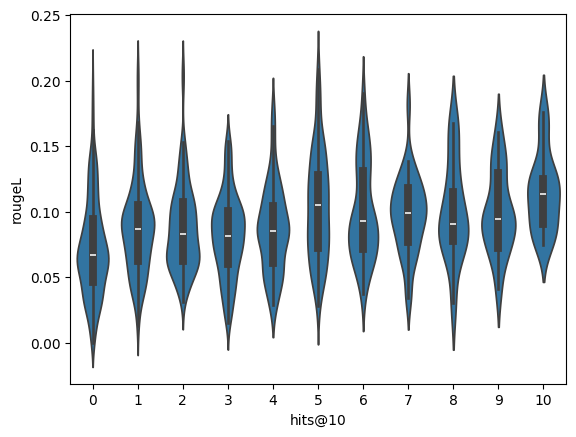

In [308]:
sns.violinplot(colbert_code_metrics_df[["hits@10", compared_metric]], x="hits@10", y=compared_metric)

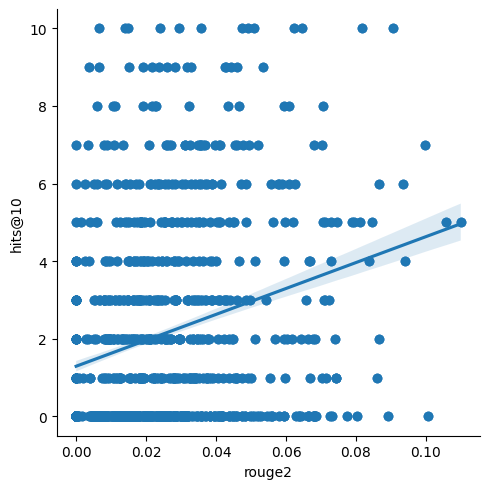

In [303]:
sns.lmplot(colbert_code_metrics_df[["hits@10", "rouge2"]], x="rouge2", y="hits@10")